<a href="https://colab.research.google.com/github/tvml/ml2021/blob/main/codici/mlp_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST: classifying handwritten digits

In [24]:
IS_COLAB = ('google.colab' in str(get_ipython()))

In [25]:
if IS_COLAB:
  %tensorflow_version 2.x

In [2]:
!pip install imageio

     |████████████████████████████████| 3.3 MB 3.3 MB/s eta 0:00:01


In [3]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import PIL
import imageio
from IPython import display
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from time import time

np.random.seed(0)

In [16]:

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import model_from_json

from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
assert tf.__version__ >= "2.0"

print(tf.__version__)
tf.config.run_functions_eagerly(True)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

ModuleNotFoundError: No module named 'keras'

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [45]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')
  filepath = "/gdrive/My Drive/colab_data/"
else:
  filepath = "../ml_store"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filepath+filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filepath+filename+".h5")
    print("Saved model to disk")

In [6]:
def load_model_weights(filename, model):
    model.load_weights(filepath+filename+".h5")
    print("Loaded weights from disk")
    return model

In [7]:
def load_model(filename):
    json_file = open(filepath+filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filepath+filename+".h5")
    print("Loaded model from disk")
    return m

In [8]:
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    #fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 16, color='C1')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

In [9]:
def plotAccuracy(acc_history_train, acc_history_test):
    plt.figure(figsize = (12,8))
    plt.plot(acc_history_train, marker='o', markersize=5, label='Train')
    plt.plot(acc_history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.show()

In [10]:
def plotData(X, Y, c, npixel=28):
    image = np.array(X[c,:])
    plt.figure(figsize = (4,4))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='gaussian')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [11]:
def plot_label_dist(predictions_probs, true_label):
  plt.figure(figsize = (4,4))
  thisplot = plt.bar(range(10), predictions_probs, color="#777777")
  plt.ylim([0, 1]) 
  thisplot[predicted_class].set_color('C0')
  thisplot[true_label].set_color('C1')
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  plt.show()

Load set of images with their correct classification. Split the set in a training set, used for learning a classifier, and a test (validation) set, used for checking the quality of the classifier

In [12]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data() 
class_names = [str(x) for x in range(10)]
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Shape of training set of images: {}. {} images of size {}x{}'.format(train_images.shape, train_images.shape[0], train_images.shape[1], train_images.shape[2]))
print('Shape of training set of images: {}. {} images of size {}x{}'.format(test_images.shape, test_images.shape[0], test_images.shape[1], test_images.shape[2]))
nb_classes = np.unique(train_labels).shape[0]
print('Number of classes: {}'.format(nb_classes))

Shape of training set of images: (60000, 28, 28). 60000 images of size 28x28
Shape of training set of images: (10000, 28, 28). 10000 images of size 28x28
Number of classes: 10


An image is coded as a matrix 28x28 reals in [0,1] (higher value = darker color)

In [13]:
for i in range(train_images.shape[1]):
    l = []
    for j in range(train_images.shape[2]):
        l.append('{0:5.3f}'.format(train_images[0,i,j]))
    print(l)

['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000

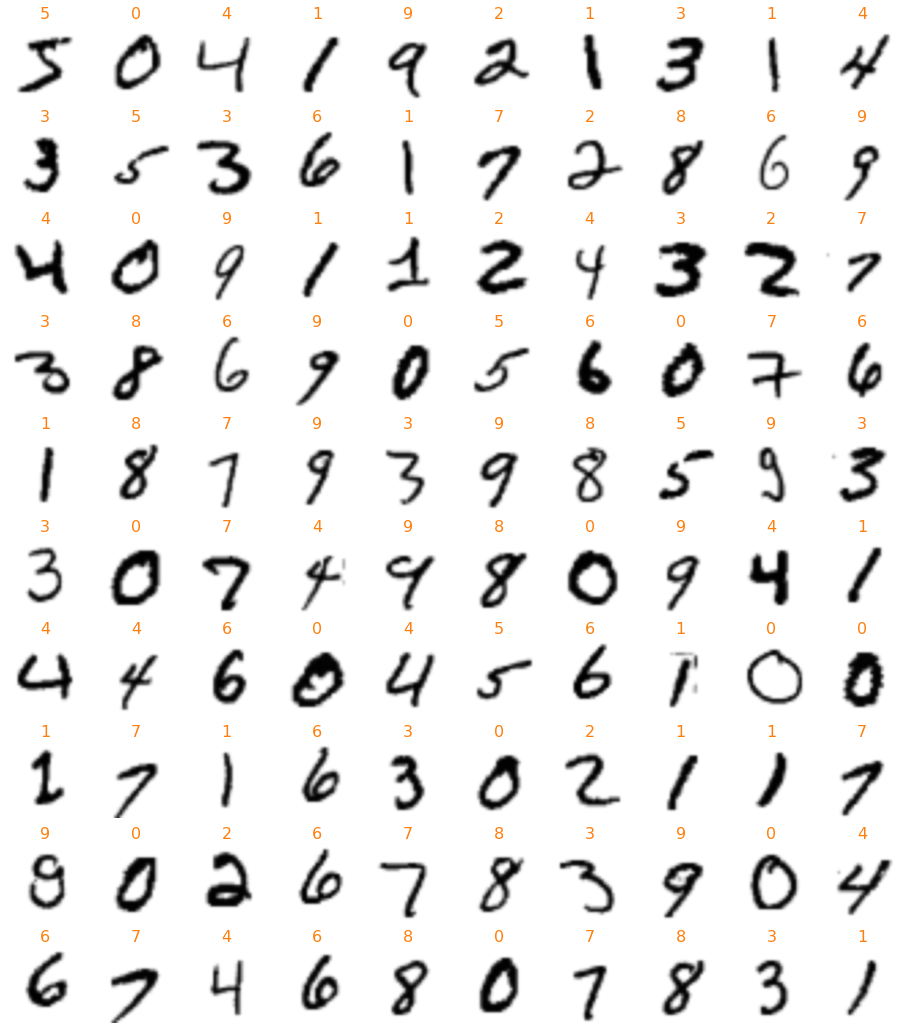

In [14]:
displayData(train_images[0:100], train_labels[0:100], class_value=True)

In [15]:
train_labels_onehot = np_utils.to_categorical(train_labels, nb_classes)
test_labels_onehot = np_utils.to_categorical(test_labels, nb_classes)

NameError: name 'np_utils' is not defined

In [39]:
print(train_labels[0:5])

[5 0 4 1 9]


In [40]:
print(train_labels_onehot[0:5,:])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


First approach: 
*   For each class, compute a linear combination of the ($28\times 28 =784$) values of the image, plus a constant (*bias*): that is, $785$ coefficients must be defined for each class, for a total number of $785\times 10=7850$ coefficients
*   For each class, the value resulting from the linear combination is *squashed* to a number in $(0,1)$ by applying it a suitable function $h:R\mapsto (0,1)$, such as the *logistic* function $$\sigma(x)=\frac{1}{1+e^{-x}}$$
*   The resulting values, one for each class, are *normalized* to sum to $1$
*   The result can be interpreted as a set of probabilities, associated to the set of disjoint events: the image belongs to the $i$-th class (it is a $0, 1, \ldots, 9$)
*   A strategy for assigning the image to a class can then be applied, such as assigning to the class of largest probability. In case, risk minimization approaches can be applied








In [17]:
model0 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model0.summary()
model0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [18]:
model0 = load_model_weights('softmax', model0)

NameError: name 'filepath' is not defined

In [195]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history0 = model0.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=1, validation_data=(test_images, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2451 - accuracy: 0.9321 - val_loss: 0.2619 - val_accuracy: 0.9281
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2441 - accuracy: 0.9329 - val_loss: 0.2644 - val_accuracy: 0.9273
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2432 - accuracy: 0.9330 - val_loss: 0.2624 - val_accuracy: 0.9274
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2428 - accuracy: 0.9326 - val_loss: 0.2653 - val_accuracy: 0.9268
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2420 - accuracy: 0.9337 - val_loss: 0.2620 - val_accuracy: 0.9297
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2414 - accuracy: 0.9338 - val_loss: 0.2617 - val_accuracy: 0.9269
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2408 - accuracy: 0.9342 - val_loss: 0.2623 - val_accuracy: 0.9268
Epoch 

In [196]:
save_model(model0, 'softmax')

Saved model to disk


In [197]:
history0_df = pd.DataFrame(history0.history)
history0_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.245090,0.932083,0.261854,0.9281
1,0.244111,0.932850,0.264443,0.9273
2,0.243221,0.933000,0.262355,0.9274
3,0.242813,0.932617,0.265282,0.9268
4,0.241960,0.933717,0.262015,0.9297


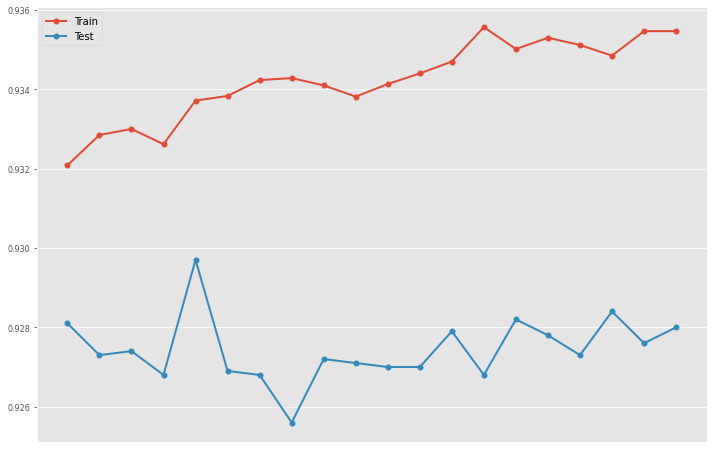

In [198]:
plotAccuracy(history0_df.accuracy, history0_df.val_accuracy)

In [143]:
predictions_train = np.argmax(model0.predict(train_images), axis=-1)

In [146]:
confusion_matrix(train_labels, predictions_train)

array([[5759,    1,   12,   11,   10,   32,   35,    6,   50,    7],
       [   1, 6579,   32,   19,    6,   19,    3,    9,   62,   12],
       [  25,   52, 5423,   91,   66,   21,   54,   65,  141,   20],
       [  16,   22,  119, 5548,    7,  164,   16,   43,  140,   56],
       [  12,   29,   25,    5, 5460,    4,   48,   13,   38,  208],
       [  48,   21,   40,  155,   54, 4799,   82,   15,  163,   44],
       [  29,   13,   36,    0,   36,   60, 5706,    3,   34,    1],
       [  13,   23,   60,   19,   44,    7,    3, 5851,   16,  229],
       [  29,   95,   44,  100,   22,  100,   31,   12, 5349,   69],
       [  20,   26,   10,   65,  103,   27,    2,  116,   51, 5529]])

In [157]:
print('Training set accuracy: {0:5.3f}'.format(accuracy_score(train_labels, predictions_train)))

Training set accuracy: 0.933


In [154]:
meas = precision_recall_fscore_support(train_labels, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 0.97, recall= 0.97, f-measure= 0.97
Class 1: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 2: precision= 0.91, recall= 0.92, f-measure= 0.92
Class 3: precision= 0.90, recall= 0.91, f-measure= 0.91
Class 4: precision= 0.93, recall= 0.94, f-measure= 0.94
Class 5: precision= 0.89, recall= 0.90, f-measure= 0.90
Class 6: precision= 0.96, recall= 0.96, f-measure= 0.96
Class 7: precision= 0.93, recall= 0.94, f-measure= 0.94
Class 8: precision= 0.91, recall= 0.90, f-measure= 0.90
Class 9: precision= 0.93, recall= 0.91, f-measure= 0.91


In [155]:
predictions_test = np.argmax(model0.predict(test_images), axis=-1)

In [156]:
confusion_matrix(test_labels, predictions_test)

array([[ 963,    0,    1,    2,    0,    5,    5,    2,    1,    1],
       [   0, 1110,    3,    2,    0,    1,    4,    2,   13,    0],
       [   6,    9,  928,   15,    6,    3,   13,    8,   40,    4],
       [   2,    0,   18,  926,    0,   17,    2,    9,   28,    8],
       [   1,    1,    5,    2,  914,    0,    8,    4,   10,   37],
       [   8,    2,    1,   41,    7,  767,   15,    7,   37,    7],
       [  10,    3,    8,    1,    7,   11,  912,    2,    4,    0],
       [   1,    6,   24,    5,    6,    1,    0,  941,    4,   40],
       [   6,    7,    6,   17,    9,   18,    7,    9,  886,    9],
       [  10,    8,    1,    7,   21,    5,    0,   11,    9,  937]])

In [158]:
print('Test set accuracy: {0:5.3f}'.format(accuracy_score(test_labels, predictions_test)))

Test set accuracy: 0.928


In [159]:
meas = precision_recall_fscore_support(test_labels, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 1: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 2: precision= 0.90, recall= 0.92, f-measure= 0.92
Class 3: precision= 0.92, recall= 0.91, f-measure= 0.91
Class 4: precision= 0.93, recall= 0.94, f-measure= 0.94
Class 5: precision= 0.86, recall= 0.89, f-measure= 0.89
Class 6: precision= 0.95, recall= 0.95, f-measure= 0.95
Class 7: precision= 0.92, recall= 0.93, f-measure= 0.93
Class 8: precision= 0.91, recall= 0.88, f-measure= 0.88
Class 9: precision= 0.93, recall= 0.91, f-measure= 0.91


Item 2046
Image shape: (28, 28)


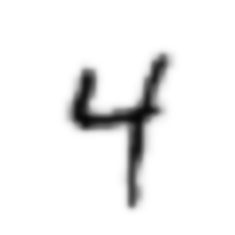

In [135]:
c = np.random.randint(0, test_images.shape[0])
img = test_images[c]
print("Item "+str(c))
print('Image shape: {}'.format(img.shape))
plotData(test_images, test_labels, c)


Shape of tensor input to model: (1, 28, 28)


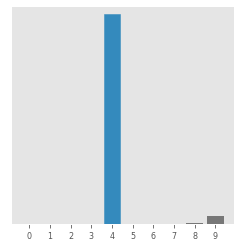

Predicted probabilities: [0.0000, 0.0000, 0.0000, 0.0000, 0.9639, 0.0003, 0.0000, 0.0001, 0.0014, 0.0341]
Class: 4. Prediction: 4


In [140]:
tensor = (np.expand_dims(img,0))
print('Shape of tensor input to model: {}'.format(tensor.shape))
predictions_probs = np.squeeze(model0.predict(tensor))
predicted_class = np.squeeze(np.argmax(predictions_probs, axis=-1))
plot_label_dist(predictions_probs, test_labels[c])
print("Predicted probabilities: ["+", ".join('%5.4f'%x for x in predictions_probs)+"]")
print("Class: "+str(test_labels[c])+". Prediction: " + str(predicted_class))

In [182]:
weights = model0.layers[1].get_weights()[0]
bias = model0.layers[1].get_weights()[1]

(10,)

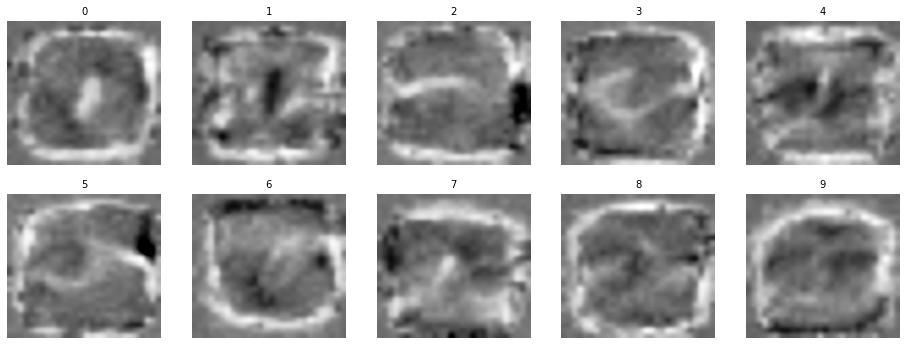

In [193]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(weights[:,i].reshape(28,28), interpolation='gaussian', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(weights[:,i])-3.5*np.std(weights[:,i]), 
           vmax=np.mean(weights[:,i])+2.5*np.std(weights[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [199]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [201]:
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [202]:
model1 = load_model_weights('nn3', model1)

Loaded weights from disk


In [203]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history1 = model1.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=1, validation_data=(test_images, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))

Epoch 1/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0744 - accuracy: 0.9781 - val_loss: 0.0739 - val_accuracy: 0.9773
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0546 - accuracy: 0.9834 - val_loss: 0.0750 - val_accuracy: 0.9767
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0408 - accuracy: 0.9878 - val_loss: 0.0643 - val_accuracy: 0.9799
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0367 - accuracy: 0.9882 - val_loss: 0.0603 - val_accuracy: 0.9823
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.0630 - val_accuracy: 0.9806
Epoch 6/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0248 - accuracy: 0.9925 - val_loss: 0.0622 - val_accuracy: 0.9802
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0195 - accuracy: 0.9942 - val_loss: 0.0624 - val_accuracy: 0.9823

In [204]:
save_model(model1,'nn3')

Saved model to disk


In [205]:
history1_df = pd.DataFrame(history1.history)
history1_df.head()


,loss,accuracy,val_loss,val_accuracy
0,0.072884,0.977933,0.073870,0.9773
1,0.055738,0.982733,0.074979,0.9767
2,0.044266,0.986500,0.064256,0.9799
3,0.036319,0.988533,0.060320,0.9823
4,0.030479,0.990350,0.062960,0.9806


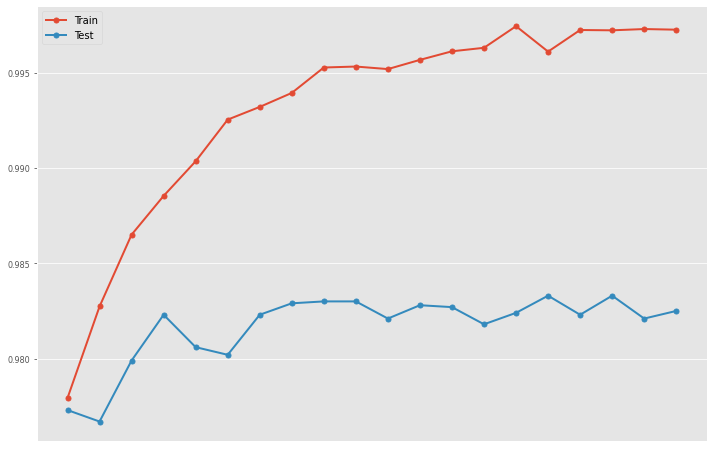

In [206]:
plotAccuracy(history1_df.accuracy, history1_df.val_accuracy)

In [208]:
predictions_train_1 = np.argmax(model1.predict(train_images), axis=-1)

In [211]:
confusion_matrix(train_labels, predictions_train_1)

array([[5922,    0,    0,    0,    0,    0,    1,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1, 5957,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    1,    0,    0, 5835,    0,    0,    1,    0,    5],
       [   0,    1,    0,    1,    0, 5418,    1,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0, 5916,    0,    1,    0],
       [   0,    7,    1,    0,    1,    0,    0, 6255,    0,    1],
       [   1,    3,    3,    5,    0,    2,    0,    0, 5837,    0],
       [   1,    1,    0,    3,    2,    2,    1,    0,    0, 5939]])

In [212]:
print('Training set accuracy: {0:5.3f}'.format(accuracy_score(train_labels, predictions_train_1)))

Training set accuracy: 0.999


In [214]:
meas = precision_recall_fscore_support(train_labels, predictions_train_1, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision=1.000, recall=1.000, f-measure=1.000
Class 1: precision=1.000, recall=0.999, f-measure=0.999
Class 2: precision=1.000, recall=1.000, f-measure=1.000
Class 3: precision=1.000, recall=0.999, f-measure=0.999
Class 4: precision=0.999, recall=0.999, f-measure=0.999
Class 5: precision=0.999, recall=0.999, f-measure=0.999
Class 6: precision=1.000, recall=1.000, f-measure=1.000
Class 7: precision=0.998, recall=0.999, f-measure=0.999
Class 8: precision=0.998, recall=0.999, f-measure=0.999
Class 9: precision=0.998, recall=0.999, f-measure=0.999


In [215]:
predictions_test_1 = np.argmax(model1.predict(test_images), axis=-1)

In [216]:
confusion_matrix(test_labels, predictions_test_1)

array([[ 972,    1,    1,    0,    2,    0,    2,    1,    1,    0],
       [   0, 1128,    2,    1,    0,    1,    1,    1,    1,    0],
       [   1,    2, 1012,    3,    2,    0,    2,    3,    5,    2],
       [   1,    0,    5,  993,    0,    3,    0,    3,    2,    3],
       [   0,    0,    3,    0,  962,    0,    4,    1,    1,   11],
       [   2,    0,    0,    8,    2,  875,    2,    0,    2,    1],
       [   4,    4,    1,    1,    1,    4,  942,    0,    1,    0],
       [   0,    5,   12,    3,    1,    0,    0, 1004,    1,    2],
       [   1,    0,    4,    5,    4,    2,    0,    3,  953,    2],
       [   2,    2,    0,    6,    6,    4,    0,    4,    1,  984]])

In [217]:
print('Test set accuracy: {0:5.3f}'.format(accuracy_score(test_labels, predictions_test_1)))

Test set accuracy: 0.983


In [219]:
meas = precision_recall_fscore_support(test_labels, predictions_test_1, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision=0.992, recall=0.990, f-measure=0.990
Class 1: precision=0.994, recall=0.991, f-measure=0.991
Class 2: precision=0.981, recall=0.977, f-measure=0.977
Class 3: precision=0.983, recall=0.978, f-measure=0.978
Class 4: precision=0.980, recall=0.981, f-measure=0.981
Class 5: precision=0.981, recall=0.983, f-measure=0.983
Class 6: precision=0.983, recall=0.986, f-measure=0.986
Class 7: precision=0.977, recall=0.980, f-measure=0.980
Class 8: precision=0.978, recall=0.981, f-measure=0.981
Class 9: precision=0.975, recall=0.977, f-measure=0.977


In [221]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
________________________________________________

In [222]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [223]:
model2 = load_model_weights('nn4', model2)

Loaded weights from disk


In [224]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=10, verbose=1, validation_data=(test_images, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))

Epoch 1/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0598 - accuracy: 0.9793 - val_loss: 0.0777 - val_accuracy: 0.9767
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0526 - accuracy: 0.9818 - val_loss: 0.0761 - val_accuracy: 0.9787
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0443 - accuracy: 0.9849 - val_loss: 0.0729 - val_accuracy: 0.9780
Epoch 4/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0332 - accuracy: 0.9888 - val_loss: 0.0744 - val_accuracy: 0.9801
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0312 - accuracy: 0.9889 - val_loss: 0.0738 - val_accuracy: 0.9801
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0704 - val_accuracy: 0.9815
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 0.0785 - val_accuracy: 0.9793

In [225]:
save_model(model2,'nn4')

Saved model to disk


In [226]:
history2_df = pd.DataFrame(history2.history)
history2_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.061992,0.979267,0.077691,0.9767
1,0.052472,0.982283,0.076124,0.9787
2,0.042016,0.985867,0.072925,0.9780
3,0.035846,0.987867,0.074400,0.9801
4,0.035400,0.987800,0.073794,0.9801


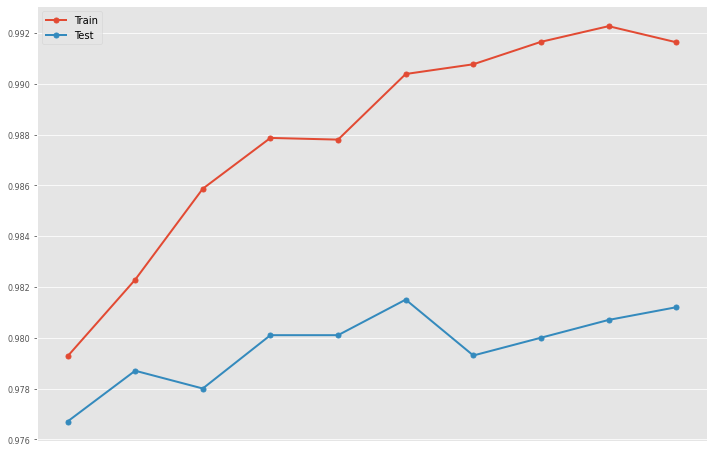

In [227]:
plotAccuracy(history2_df.accuracy, history2_df.val_accuracy)

In [237]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(30, (5, 5), input_shape=(28, 28,1), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(15, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)             

In [238]:
model3.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [240]:
model3 = load_model_weights('cnn', model3)

Loaded weights from disk


In [242]:
train_images_tensor = train_images.reshape(train_images.shape[0], 28, 28,1).astype('float32')
test_images_tensor = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [245]:
tf.config.run_functions_eagerly(True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history3 = model3.fit(train_images_tensor, train_labels, batch_size=128, epochs=10, verbose=1, validation_data=(test_images_tensor, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
469/469 [==============================] - 55s 116ms/step - loss: 0.0584 - accuracy: 0.9815 - val_loss: 0.0313 - val_accuracy: 0.9891
Epoch 2/10
469/469 [==============================] - 54s 116ms/step - loss: 0.0478 - accuracy: 0.9850 - val_loss: 0.0289 - val_accuracy: 0.9900
Epoch 3/10
469/469 [==============================] - 54s 116ms/step - loss: 0.0409 - accuracy: 0.9873 - val_loss: 0.0244 - val_accuracy: 0.9917
Epoch 4/10
469/469 [==============================] - 54s 116ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.0245 - val_accuracy: 0.9922
Epoch 5/10
469/469 [==============================] - 54s 116ms/step - loss: 0.0336 - accuracy: 0.9890 - val_loss: 0.0247 - val_accuracy: 0.9908
Epoch 6/10
469/469 [==============================] - 55s 116ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0241 - val_accuracy: 0.9927
Epoch 7/10
469/469 [==============================] - 54s 116ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0273 - val_ac

In [247]:
save_model(model3,'cnn')

Saved model to disk


In [248]:
history3_df = pd.DataFrame(history3.history) 
history3_df.head()


,loss,accuracy,val_loss,val_accuracy
0,0.058359,0.981517,0.031345,0.9891
1,0.047752,0.984983,0.028890,0.9900
2,0.040945,0.987317,0.024380,0.9917
3,0.037397,0.987617,0.024522,0.9922
4,0.033555,0.989000,0.024675,0.9908


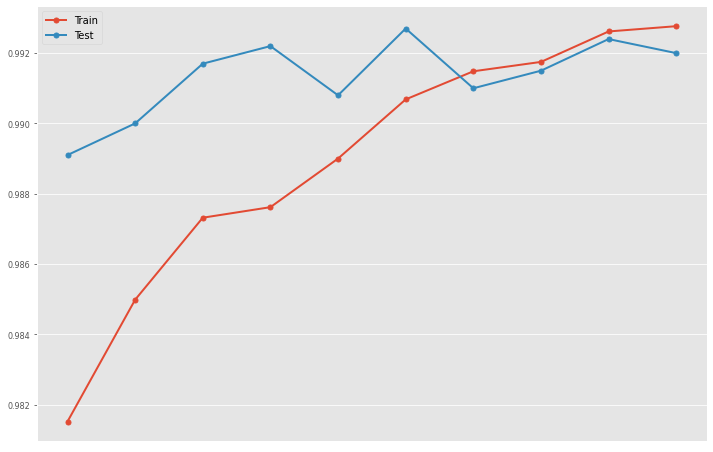

In [249]:
plotAccuracy(history3_df.accuracy, history3_df.val_accuracy)